### Finetuning SAM with 2D neuron data (MIP) (Noised images)

##### Setup notebook and import data

In [36]:
# Install the required libraries
#SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
!pip install -q git+https://github.com/huggingface/transformers.git

  Cloning https://github.com/facebookresearch/segment-anything.git to c:\users\harry\appdata\local\temp\pip-req-build-gaqvwe33
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 526fd066dea338ba2ca08886853bd37ffd6a8aec
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git 'C:\Users\harry\AppData\Local\Temp\pip-req-build-gaqvwe33'


In [2]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tifffile
import os
import random
from scipy import ndimage
from glob import glob
import cv2
import datasets
from PIL import Image
from torch.utils.data import Dataset
from transformers import SamProcessor, SamModel, SamConfig
from torch.optim import Adam
import monai
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [3]:
# Give file directories
image_dir = "images/fin/mips/2dnoisymips"
label_dir = "images/fin/mips/labels"

# Find file paths and sort
image_paths = sorted(glob(os.path.join(image_dir, "*")))
label_paths = sorted(glob(os.path.join(label_dir, "*")))

In [4]:
images = []
labels = []

for path in image_paths:
  image = tifffile.imread(path)
  images.append(image)

for path in label_paths:
  label = tifffile.imread(path)
  labels.append(label)

##### Preprocess data

In [5]:
# Resize the image and mask to the target size
target_size = (256, 256)

resized_images = []
resized_masks = []

for (image), (label) in zip(images, labels):
    image = cv2.resize(image, target_size)
    mask = cv2.resize(label, target_size, interpolation=cv2.INTER_NEAREST)

    resized_images.append(image)
    resized_masks.append(mask)

resized_images = np.array(resized_images)
resized_masks = np.array(resized_masks)

In [6]:
resized_masks.shape

(36, 256, 256)

In [7]:
# Normalise mask values 0,1
resized_masks = resized_masks / 255

In [8]:
np.unique(resized_masks)

array([0., 1.])

In [9]:
# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in resized_images],
    "label": [Image.fromarray(mask) for mask in resized_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = datasets.Dataset.from_dict(dataset_dict)

In [10]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 36
})

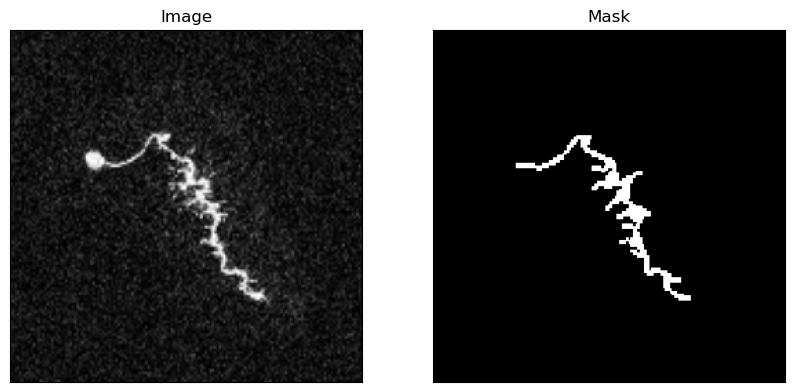

In [11]:
# Plot image and mask at random

img_num = random.randint(0, resized_images.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the image
axes[0].imshow(np.array(example_image), cmap='gray')
axes[0].set_title("Image")

# Plot the mask
axes[1].imshow(np.array(example_mask), cmap='gray')
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

plt.show()

In [12]:
# Get bounding boxes from mask which are then overlayed onto image for prompt

def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)

  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

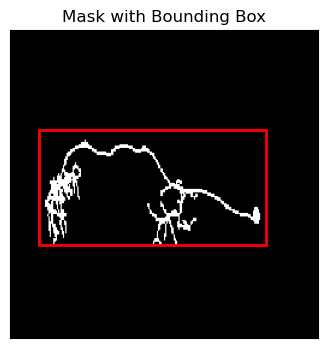

In [13]:
# Sample an item from the dataset
img_num = random.randint(0, resized_masks.shape[0]-1)
item = dataset[img_num]

example_mask = dataset[img_num]["label"]
example_mask = np.array(example_mask)

# Get the bounding box from the mask
bbox = get_bounding_box(example_mask)

# Plot the image and mask with the bounding box
fig, ax = plt.subplots(figsize=(8, 4))

# Show the mask
ax.imshow(example_mask, cmap='gray')

# Create a rectangle patch for the bounding box
rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=2, edgecolor='r', facecolor='none')

# Add the rectangle to the plot
ax.add_patch(rect)

# Set the title and hide axis ticks
ax.set_title("Mask with Bounding Box")
ax.set_xticks([])
ax.set_yticks([])

plt.show()

In [14]:
# Split into train and test sets
train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)

train_set = torch.utils.data.Subset(dataset, train_indices)
test_set = torch.utils.data.Subset(dataset, test_indices)

##### Setup dataset class

In [15]:
class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]

    # Convert to numpy array
    image = np.array(image)

    # Check if the image is greyscale and if so convert to RGB
    if image.ndim == 2:
        image = np.expand_dims(image, axis=-1)
        image = np.repeat(image, 3, axis=2)

    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [16]:
# Initialise processor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [17]:
# Create train and test instances of SAMDataset
train_dataset = SAMDataset(dataset=train_set, processor=processor)
test_dataset = SAMDataset(dataset=test_set, processor=processor)

In [18]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [19]:
# Create a DataLoader instance for the training and test sets
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True)

In [20]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [21]:
batch = next(iter(test_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [22]:
# Metric and plotting functions

def iou_score(segmentation, gt):
    """A function to compute IoU"""
    intersection = (segmentation*gt).sum()
    union = segmentation.sum() + gt.sum() - intersection
    score = intersection / union
    return score

def dice_score(segmentation, gt):
    """A function to compute Dice coefficient"""
    intersection = (segmentation*gt).sum()
    score = (2. *intersection) / (segmentation.sum() + gt.sum())
    return score

##### Setup training

In [23]:
# Load the model
model = SamModel.from_pretrained("facebook/sam-vit-base")

# Ensure we only fine-tune the mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [24]:
# Initialise the optimiser and select hyperparameters
optimiser = Adam(model.mask_decoder.parameters(), lr=1e-4, weight_decay=0)

# Initalise DiceLoss function
seg_loss = monai.losses.DiceLoss(sigmoid=True)

In [25]:
# Training loop

# Define number of epochs
num_epochs = 25

# Set model to cuda device
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

training_losses = []
test_losses_score = []
dice_scores_test = []
iou_scores_test = []


# Start training loop
for epoch in range(num_epochs):
  # Put model into train mode
  model.train()

  epoch_losses = []

  # Loop for each batch in training data
  for batch in tqdm(train_dataloader):
    # Forward pass for each batch input upscaled image and bounding box data into model to get output and place in device memory
    outputs = model(pixel_values=batch["pixel_values"].to(device),
                    input_boxes=batch["input_boxes"].to(device),
                    multimask_output=False)

    # Outputs logits of segmentation mask
    segmentation_logit = outputs.pred_masks.squeeze(1)

    # Load mask from batch and convert to same dtype and size as segmentation
    gt_mask = batch["ground_truth_mask"].unsqueeze(1).float().to(device)

    # Calculate loss (Diceloss)
    loss = seg_loss(segmentation_logit, gt_mask)

    # Backward pass
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

    # Append loss for batch to epoch loss list
    epoch_losses.append(loss.item())

  # Calculate mean loss for epoch
  training_losses.append(mean(epoch_losses))
  print(f"Epoch: {epoch+1}, Loss: {mean(epoch_losses)}")

  # Put model into eval mode
  model.eval()

  # Instantiate empty lists for metrics
  test_losses = []
  dice_scores = []
  iou_scores = []

  # Ensure no weights are altered
  with torch.no_grad():
    for batch in tqdm(test_dataloader):

      # Forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # Compute loss
      segmentation_logit = outputs.pred_masks.squeeze(1)
      gt_mask = batch["ground_truth_mask"].unsqueeze(1).float().to(device)

      loss = seg_loss(segmentation_logit, gt_mask)

      # Append loss for batch to epoch loss list
      test_losses.append(loss.item())

      # Convert logits with sigmoid function
      segmentation_prob = torch.sigmoid(segmentation_logit)

      # Convert probability map to binary
      predicted_mask_bin = ((segmentation_prob) > 0.5).float()

      # Compute Dice and IoU metrics
      dice = dice_score(predicted_mask_bin, gt_mask)
      iou = iou_score(predicted_mask_bin, gt_mask)

      # Append metrics to lists
      dice_scores.append(dice.item())
      iou_scores.append(iou.item())

    test_losses_score.append(mean(test_losses))
    iou_scores_test.append(mean(iou_scores))
    dice_scores_test.append(mean(dice_scores))

    print(f"Epoch: {epoch+1}, test loss: {mean(test_losses)}, test iou: {mean(iou_scores)}, test dice: {mean(dice_scores)}")

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.39it/s]


Epoch: 1, Loss: 0.44743054040840696


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.24it/s]


Epoch: 1, test loss: 0.39741644263267517, test iou: 0.42995696514844894, test dice: 0.5966538637876511


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.07it/s]


Epoch: 2, Loss: 0.38664079776832033


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.19it/s]


Epoch: 2, test loss: 0.3824947774410248, test iou: 0.46019846946001053, test dice: 0.6284022778272629


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  2.95it/s]


Epoch: 3, Loss: 0.3528090055499758


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.07it/s]


Epoch: 3, test loss: 0.3741714209318161, test iou: 0.46852055937051773, test dice: 0.6370446383953094


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.26it/s]


Epoch: 4, Loss: 0.3318285814353398


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.08it/s]


Epoch: 4, test loss: 0.3717808499932289, test iou: 0.4787890687584877, test dice: 0.6469474732875824


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.03it/s]


Epoch: 5, Loss: 0.3261452317237854


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.02it/s]


Epoch: 5, test loss: 0.36749492585659027, test iou: 0.46208298206329346, test dice: 0.6281754225492477


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  2.88it/s]


Epoch: 6, Loss: 0.3216322064399719


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.19it/s]


Epoch: 6, test loss: 0.37421422451734543, test iou: 0.472113661468029, test dice: 0.6405485272407532


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.06it/s]


Epoch: 7, Loss: 0.33466736972332


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.02it/s]


Epoch: 7, test loss: 0.3786296397447586, test iou: 0.47165172547101974, test dice: 0.6400207877159119


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  2.90it/s]


Epoch: 8, Loss: 0.3185556637389319


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.16it/s]


Epoch: 8, test loss: 0.3757283687591553, test iou: 0.46980810910463333, test dice: 0.6379498392343521


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  2.96it/s]


Epoch: 9, Loss: 0.31293162064892904


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.19it/s]


Epoch: 9, test loss: 0.37944138050079346, test iou: 0.4714086130261421, test dice: 0.6396915316581726


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.05it/s]


Epoch: 10, Loss: 0.31826568075588774


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.99it/s]


Epoch: 10, test loss: 0.37156980484724045, test iou: 0.46806327998638153, test dice: 0.636880099773407


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.04it/s]


Epoch: 11, Loss: 0.31012805657727377


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.10it/s]


Epoch: 11, test loss: 0.37317372113466263, test iou: 0.4585573300719261, test dice: 0.6259979158639908


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.02it/s]


Epoch: 12, Loss: 0.303361462695258


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.00it/s]


Epoch: 12, test loss: 0.37717001140117645, test iou: 0.4756712019443512, test dice: 0.6439879834651947


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.07it/s]


Epoch: 13, Loss: 0.2988855093717575


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.20it/s]


Epoch: 13, test loss: 0.3732324242591858, test iou: 0.47734079509973526, test dice: 0.6456208974123001


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.09it/s]


Epoch: 14, Loss: 0.3003336467913219


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.14it/s]


Epoch: 14, test loss: 0.3668903335928917, test iou: 0.4703788459300995, test dice: 0.6366569697856903


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.01it/s]


Epoch: 15, Loss: 0.2980384847947529


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.10it/s]


Epoch: 15, test loss: 0.3767336830496788, test iou: 0.46275559812784195, test dice: 0.6284099221229553


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.08it/s]


Epoch: 16, Loss: 0.29640589228698183


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.19it/s]


Epoch: 16, test loss: 0.37008409947156906, test iou: 0.4667488932609558, test dice: 0.6356848031282425


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.10it/s]


Epoch: 17, Loss: 0.308137908577919


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.24it/s]


Epoch: 17, test loss: 0.3712352588772774, test iou: 0.47762858867645264, test dice: 0.6450390815734863


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.11it/s]


Epoch: 18, Loss: 0.3044843907867159


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.20it/s]


Epoch: 18, test loss: 0.377495214343071, test iou: 0.4564318135380745, test dice: 0.62504543364048


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.11it/s]


Epoch: 19, Loss: 0.29779685182230814


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.20it/s]


Epoch: 19, test loss: 0.3718255087733269, test iou: 0.46023860573768616, test dice: 0.6271741688251495


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.11it/s]


Epoch: 20, Loss: 0.29440560936927795


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.20it/s]


Epoch: 20, test loss: 0.3765748515725136, test iou: 0.47238196432590485, test dice: 0.6404853910207748


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.10it/s]


Epoch: 21, Loss: 0.29011910940919605


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.20it/s]


Epoch: 21, test loss: 0.3754945546388626, test iou: 0.46195996552705765, test dice: 0.6298038512468338


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.09it/s]


Epoch: 22, Loss: 0.2888279855251312


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.21it/s]


Epoch: 22, test loss: 0.37291219830513, test iou: 0.46213286370038986, test dice: 0.6302140206098557


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.05it/s]


Epoch: 23, Loss: 0.2888397233826773


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.11it/s]


Epoch: 23, test loss: 0.3730817884206772, test iou: 0.47117476165294647, test dice: 0.6400932222604752


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.02it/s]


Epoch: 24, Loss: 0.2847623122589929


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.10it/s]


Epoch: 24, test loss: 0.3723946884274483, test iou: 0.4721791297197342, test dice: 0.6399247944355011


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.07it/s]


Epoch: 25, Loss: 0.28347151620047434


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.11it/s]

Epoch: 25, test loss: 0.3803207278251648, test iou: 0.4558647871017456, test dice: 0.6230724602937698


##### Show metrics

In [26]:
results_dir = "output/noisy/2d_sam_noisy_metrics"

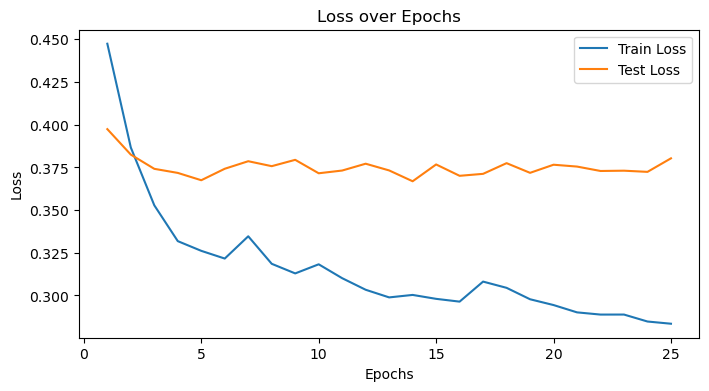

In [27]:
# Plot loss metrics

plt.figure(figsize=(8, 4))

epochs = range(1, num_epochs + 1)

plt.plot(epochs, training_losses, label='Train Loss')
plt.plot(epochs, test_losses_score, label='Test Loss')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.savefig(f"{results_dir}/noisy_2d_sam_loss_results.png")
plt.show()

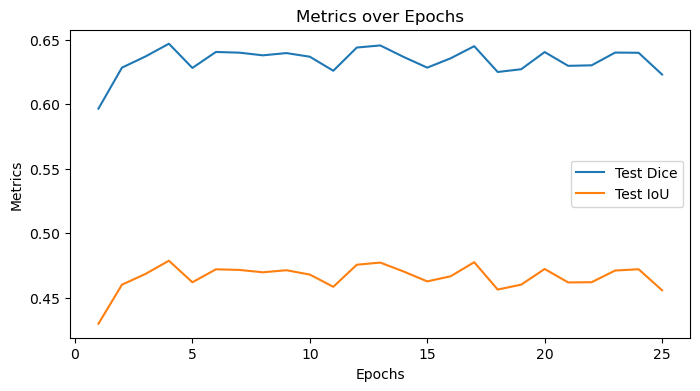

In [28]:
# Plot evaluation metrics

plt.figure(figsize=(8,4))

epochs = range(1, num_epochs + 1)

plt.plot(epochs, dice_scores_test, label="Test Dice")
plt.plot(epochs, iou_scores_test, label='Test IoU')

plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.title("Metrics over Epochs")
plt.legend()

plt.savefig(f"{results_dir}/2d_noisy_sam_metrics_results.png")
plt.show()

In [29]:
# Save the model
torch.save(model.state_dict(), "models/2D_noisy_SAM_25.pth")

##### Inference

In [30]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_model = SamModel(config=model_config)

# Update the model by loading the weights from saved file.
my_model.load_state_dict(torch.load("models/2D_noisy_SAM_25.pth"))

C:\Users\harry\AppData\Local\Temp\ipykernel_912\3905088296.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  my_model.load_state_dict(torch.load("models/2D_noisy_SAM_25.pt

<All keys matched successfully>

In [28]:
# Check number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 93735472


In [31]:
# Import inference images and masks
img_dir = 'images/fin/inf_set/2dnoisyimages'
lab_dir = 'images/fin/inf_set/2Dlabels'

image_paths = sorted(glob(os.path.join(img_dir, "*.tif")))
label_paths = sorted(glob(os.path.join(lab_dir, "*.tif")))

In [32]:
inf_images = []
inf_masks = []

# Preprocess each 2D image and ground truth mask
target_size = (256, 256)

for image_path, label_path in zip(image_paths, label_paths):
    inf_image = tifffile.imread(image_path)
    inf_mask = tifffile.imread(label_path)

    # Resize each image and mask to the target size
    resized_image = cv2.resize(inf_image, target_size)
    resized_mask = cv2.resize(inf_mask, target_size, interpolation=cv2.INTER_NEAREST)

    inf_images.append(resized_image)
    inf_masks.append(resized_mask)

# Convert lists to numpy arrays for inference
inf_images = np.array(inf_images)
inf_masks = np.array(inf_masks)

print(f"Number of images loaded: {len(inf_images)}")
print(f"Shape of the first image: {inf_images[0].shape}")
print(f"Shape of the first mask: {inf_masks[0].shape}")

Number of images loaded: 4
Shape of the first image: (256, 256)
Shape of the first mask: (256, 256)


In [33]:
# set the model to device
device = "cuda" if torch.cuda.is_available() else "cpu"
my_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [34]:
# Output folder to save figures
output_dir_figs = "output/noisy/2d_sam_noisy_inf"

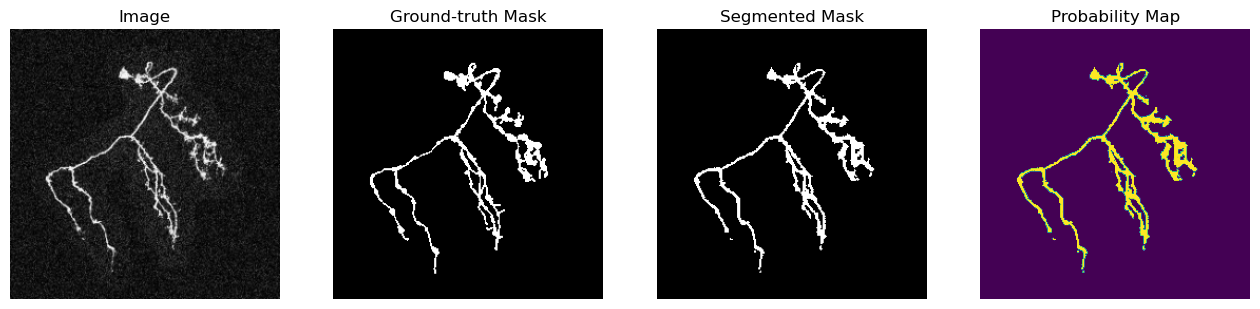

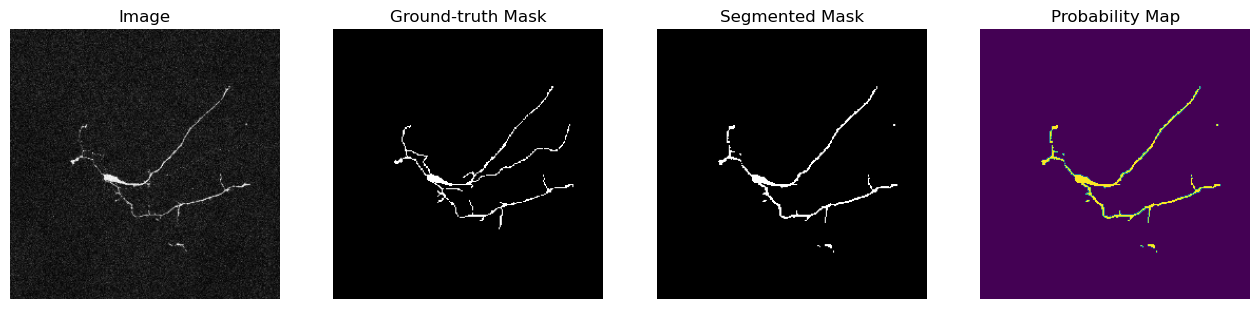

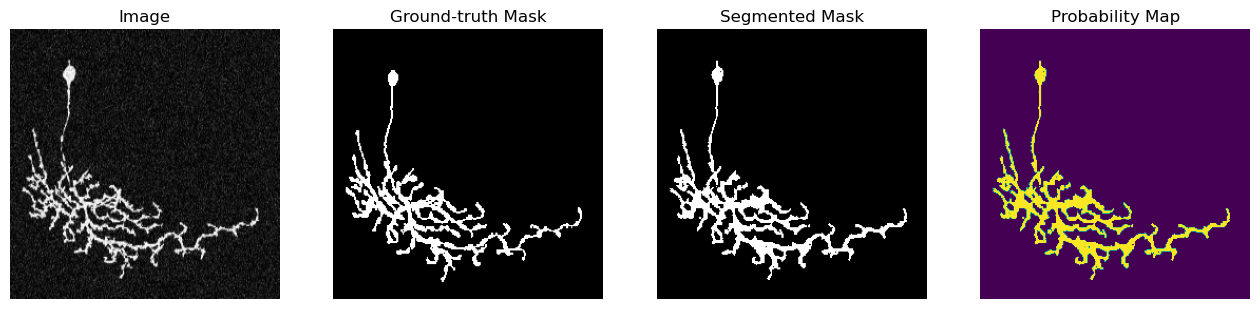

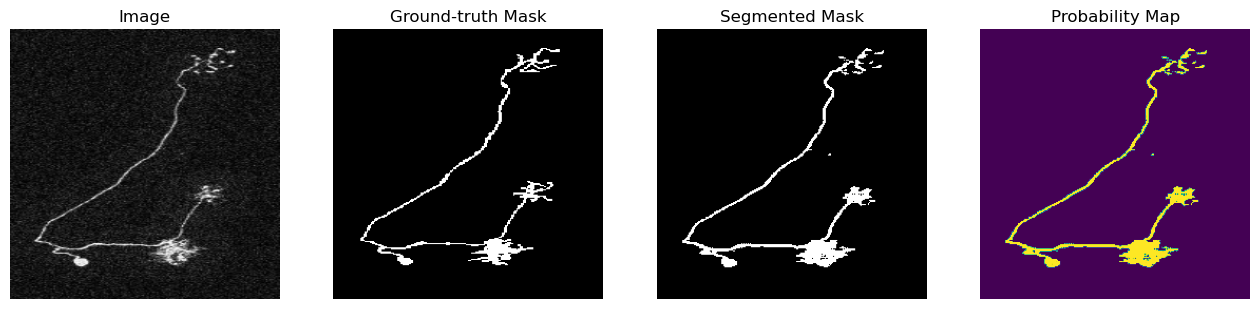

In [35]:
# Inference loop

for idx, (test_image, ground_truth_mask) in enumerate(zip(inf_images, inf_masks)):
    # Convert to RGB if grayscale
    if test_image.ndim == 2:
        test_image = np.expand_dims(test_image, axis=-1)
        test_image = np.repeat(test_image, 3, axis=2)

    # Get box prompt from the ground truth mask
    prompt = get_bounding_box(ground_truth_mask)

    # Prepare image + box prompt for the model
    inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

    # Move the input tensor to the GPU
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Put into inference mode
    my_model.eval()

    # Forward pass with no changing of weights
    with torch.no_grad():
        outputs = my_model(**inputs, multimask_output=False)

    # Apply sigmoid and thresholding
    segmentation_prob = torch.sigmoid(outputs.pred_masks.squeeze(1)).cpu().numpy().squeeze()
    bin_segmentation = (segmentation_prob > 0.5).astype(np.uint8)

    # Plot the original image, ground truth, segmentation, and probability map
    fig, axes = plt.subplots(1, 4, figsize=(16, 5))

    # Plot the original image
    axes[0].imshow(test_image, cmap='gray')
    axes[0].set_title("Image")
    axes[0].axis("off")

    # Plot the ground-truth mask
    axes[1].imshow(ground_truth_mask, cmap='gray')
    axes[1].set_title("Ground-truth Mask")
    axes[1].axis("off")

    # Plot the binary segmentation mask
    axes[2].imshow(bin_segmentation, cmap='gray')
    axes[2].set_title("Segmented Mask")
    axes[2].axis("off")

    # Plot the probability map
    im = axes[3].imshow(segmentation_prob, cmap='viridis', vmin=0, vmax=1)
    axes[3].set_title("Probability Map")
    axes[3].axis("off")

    # Save the figure with a unique index
    plt.savefig(f"{output_dir_figs}/2D_SAM_inference_results_{idx}.png", bbox_inches='tight', pad_inches=1)
    plt.show()
